In [1]:
import os

import numpy as np
import math
import uproot as uproot
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import gridspec
import dunestyle.matplotlib as dunestyle

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import median_abs_deviation
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import Bounds, LinearConstraint
from scipy.stats import chisquare

from landaupy import langauss

from branches import *
from pandas_helpers import *

DUNE plot style enabled


In [2]:
## Functions for Langau fit
def fit_langauss(x, y, y_err):
	area_guess = np.sum(y) * 0.05 / (x[1] - x[0])
	landau_x_mpv_guess = x[np.argmax(y)]
	landau_xi_guess = 0.1
	gauss_sigma_guess = 0.1
	popt, pcov = curve_fit(
		lambda x, area, mpv, xi, g_sigma: area * langauss.pdf(x, mpv, xi, g_sigma),
		xdata = x,
		ydata = y,
		sigma = y_err,
		p0 = [area_guess, landau_x_mpv_guess, landau_xi_guess, gauss_sigma_guess],
	)
	return popt, pcov

def langau_func(x, area, mpv, xi, g_sigma):
    return area * langauss.pdf(x, mpv, xi, g_sigma)

def rr_to_str(rr):
    rr_str = ""
    if(rr < 10):
        rr_str = "0"
        rr_str = rr_str + format(rr, '.2f') + "cm"
    else:
        rr_str = format(rr, '.2f') + "cm"
    return rr_str

def rr_vs_dedx_langau(hitdf, prefix, suffix):
    rr_min = 3.0
    rr_max = 120.0
    rr_step = 1.0
    this_hitdf = hitdf
    this_hitdf['rr_bins'] = pd.cut(this_hitdf['rr'], bins=np.arange(rr_min, rr_max + rr_step, rr_step))
    rr_group_df = this_hitdf.groupby('rr_bins')

    out_df = pd.DataFrame({
        'rr': [],
        'MPV': [],
        'MPV_err': [],
        'sigma_L': [],
        'sigma_L_err': [],
        'sigma_G': [],
        'sigma_G_err': []
    })

    for i, (group_name, group_data) in enumerate(rr_group_df):
        rr_low = rr_min + rr_step * i
        rr_high = rr_min + rr_step * (i + 1)
        this_file_name = './plots/rr_vs_dedx/1d/' + prefix + 'dedx_' + rr_to_str(rr_low) + 'to' + rr_to_str(rr_high) + suffix + '.pdf'
    
        y, bin_edges = np.histogram(group_data['dedx'], bins=100, range = (0., 10.))
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        mask = np.nonzero(y)
        
        fig, ax = plt.subplots()        
        plt.errorbar(
            x = bin_centers[mask],
            y = y[mask],
            yerr = y[mask]**0.5,
            linewidth=2, capsize=1,
            fmt='ok',
            drawstyle = 'default'
        )
        #plt.title(' ')
        #plt.title(f'Residual range : {group_name} [cm]')
        plt.xlabel(r'$\mathrm{\frac{dE}{dx}~[MeV/cm]}$')
        plt.ylabel('Entries')
        ax.set_ylim(bottom=0)
        
        #popt  : 1 = MPV, 2 = sigma_L, 3 = sigma_G
        popt, pcov = fit_langauss(bin_centers[mask], y[mask], y[mask]**0.5)
        this_rr_center = (rr_high + rr_low) / 2.
        this_MPV_err = pcov[1][1]
        this_sigma_L_err = pcov[2][2]
        this_sigma_G_err = pcov[3][3]

        this_row = {
            'rr': this_rr_center,
            'MPV': popt[1],
            'MPV_err': this_MPV_err,
            'sigma_L': popt[2],
            'sigma_L_err': this_sigma_L_err,
            'sigma_G': popt[3],
            'sigma_G_err': this_sigma_G_err
        }

        out_df = out_df.append(this_row, ignore_index=True)        

        n_div = 500
        curve_x = np.linspace(bin_centers[0], bin_centers[-1], n_div)
        plt.plot(curve_x, langau_func(curve_x, *popt), 'r-', label=r'MPV=%5.2f' % popt[1])
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{L}}$=%5.2f' % popt[2])
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{G}}$=%5.2f' % popt[3])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
        ax.text(0.50, 0.95, f'Residual range\n{group_name} [cm]', transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)
        plt.legend(loc=(0.50, 0.45), fontsize=18)
        #plt.show()
        plt.savefig(this_file_name, bbox_inches='tight', pad_inches=0.1)
        #if i > 2:
        #    break
        plt.close(fig)


    return out_df

In [3]:
## Load pickle file
out_path = "/Users/sungbino/Study/FNAL/SBND/calib/chi2_pid/pickle/"
with open(os.path.join(out_path, "hit0_sel_df.pkl"), 'rb') as f:
    hit0_sel_df = pickle.load(f)

In [4]:
hit0_sel_df[('chi2pid', 'I2', 'chi2_muon')]
#column_list = 

0          36.603680
1          36.603680
2          36.603680
3          36.603680
4          36.603680
             ...    
2429883    15.035535
2429884    15.035535
2429885    15.035535
2429886    15.035535
2429887    15.035535
Name: (chi2pid, I2, chi2_muon), Length: 2429888, dtype: float32

In [5]:
pdg_list = hit0_sel_df[('p', 'pdg', '')].value_counts()
print(pdg_list)

 13      2251437
 2212      87863
 211       40364
-13        33790
-211       14208
 22         1977
 321         249
Name: (p, pdg, ), dtype: int64


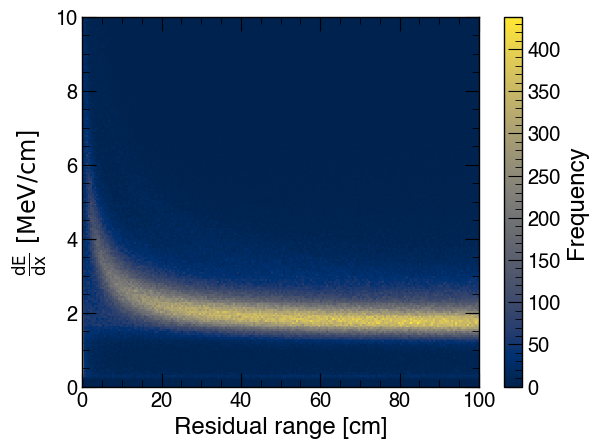

In [6]:
plt.hist2d(hit0_sel_df['rr'], hit0_sel_df['dedx'], bins=200, range = [[0, 100],[0,10]])
plt.colorbar(label='Frequency')
plt.xlabel('Residual range [cm]')
plt.ylabel(r'$\mathrm{\frac{dE}{dx}~[MeV/cm]}$')
plt.savefig('./plots/rr_vs_dedx/2d/rr_vs_dedx_GENIE_CV.pdf')
plt.show()

In [7]:
langau_fit_par_df = rr_vs_dedx_langau(hit0_sel_df, "plane0_", "")

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/3660595556.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(this_row, ignore_index=True)
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/3660595556.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(this_row, ignore_index=True)
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/3660595556.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(this_row, ignore_index=True)
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/3660595556.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [29]:
langau_fit_par_df['sigma_G_err']
negative_sigma_G_rr = langau_fit_par_df[langau_fit_par_df['sigma_G_err'] < 0.]
print(negative_sigma_G_rr)

Empty DataFrame
Columns: [rr, MPV, MPV_err, sigma_L, sigma_L_err, sigma_G, sigma_G_err]
Index: []


In [81]:
def func_dedx_res(x, a0, a1):
    return x * (a0 + a1 * x * x)

def func_deex_res_v1(x, a0, a1, a2):
    return (a0 + a1 * x + a2 * x *x + a3 * x * x * x)


def fit_result_vs_rr(fit_par_df, parname, y_title, prefix, suffix, ymin, ymax, draw_fit_result):
    rr_min = 18.0
    rr_max = 120.0
    cut_rr_min = (fit_par_df.rr > rr_min)
    this_par_df = fit_par_df[cut_rr_min]

    this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))

    fig, ax = plt.subplots()        
    plt.errorbar(
        x = this_par_df['rr'],
        y = this_par_df[parname],
        yerr = this_par_df[parname + '_err'],
        linewidth=2, capsize=1,
        fmt='ok',
        drawstyle = 'default',
        label = 'SBND MC GENIE CV Fit',
        zorder=1
    )
    plt.xlabel('Residual range [cm]')
    plt.ylabel(y_title)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=ymin, top = ymax)

    # dE/dx res function in LArSoft Chi2PIDAlg
    if parname == 'sigma_G':
        plt.plot(this_par_df['rr'], this_par_df['sigma_G_LArSoft'], 'r-', label='LArSoft Chi2PIDAlg')
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{Gauss}}= \frac{dE}{dx} \left( 0.04231 + 0.0001783 \frac{dE}{dx} \times \frac{dE}{dx} \right)$')

        if draw_fit_result:
            this_par_df['sigma_G_fit'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.10419, 0.0118460))
            print(this_par_df['sigma_G_fit'])
            plt.plot(this_par_df['rr'], this_par_df['sigma_G_fit'], 'r-', label='Fit result', color='blue', linestyle='--')
            plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{Gauss}}= \frac{dE}{dx} \left( 0.10419 + 0.0118460 \frac{dE}{dx} \times \frac{dE}{dx} \right)$')


    plt.legend(bbox_to_anchor=(0.20, 0.88), loc='upper left', fontsize=12)
    save_str = './plots/dedx_res/rr_vs_' + parname + '_GENIE_CV.pdf'
    if draw_fit_result:
        save_str = './plots/dedx_res/rr_vs_' + parname + '_GENIE_CV_fit.pdf'
    plt.savefig(save_str)

def fit_result_vs_MPV(fit_par_df, parname, y_title, prefix, suffix, do_fit):
    rr_min = 18.0
    rr_max = 120.0
    cut_rr_min = (fit_par_df.rr > rr_min)
    this_par_df = fit_par_df[cut_rr_min]

    this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))
    this_x = this_par_df['MPV']
    this_x_err = this_par_df['MPV_err']
    this_y = this_par_df[parname]
    this_y_err = this_par_df[parname + '_err']

    fig, ax = plt.subplots()        
    plt.errorbar(
        x = this_x,
        xerr = this_x_err,
        y = this_y,
        yerr = this_y_err,
        linewidth=2, capsize=1,
        fmt='ok',
        drawstyle = 'default',
        label = 'SBND MC GENIE CV Fit',
        zorder=1
    )
    plt.xlabel('MPV dE/dx [MeV/cm]')
    plt.ylabel(y_title)
    ax.set_xlim(left=1.6)
    ax.set_ylim(bottom=0., top = 0.7)

    # dE/dx res function in LArSoft Chi2PIDAlg
    if parname == 'sigma_G':
        plt.plot(this_par_df['MPV'], this_par_df['sigma_G_LArSoft'], 'r-', label='LArSoft Chi2PIDAlg')
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{G}}= \frac{dE}{dx} \left( 0.04231 + 0.0001783 \frac{dE}{dx} \times \frac{dE}{dx} \right)$')

        if do_fit:
            popt, pcov = curve_fit(
        		func_dedx_res,
		        xdata = this_x,
		        ydata = this_y,
		        sigma = this_y_err,
		        p0 = [0.04231, 0.0001783],
	        )

            fit_a0 = popt[0]
            fit_a0_err = pcov[0][0]
            fit_a1 = popt[1]
            fit_a1_err = pcov[1][1]
            fit_result_x = np.linspace(1.65, 2.45, 500)
            plt.plot(fit_result_x, func_dedx_res(fit_result_x, *popt), 'r-', label='Fit result', color='blue', linestyle='--')
            plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{G}}= \frac{dE}{dx} \left( %5.5f + %5.7f \frac{dE}{dx} \times \frac{dE}{dx} \right)$' % (popt[0], popt[1]))
            #plt.plot([], [], ' ', label=r'$\mathrm{{a}_{0}}$=%5.5f' % popt[0])
            #plt.plot([], [], ' ', label=r'$\mathrm{{a}_{1}}$=%5.7f' % popt[1])

    plt.legend(bbox_to_anchor=(0.10, 0.93), loc='upper left', fontsize=12)
    save_str = './plots/dedx_res/MPV_vs_' + parname + '_GENIE_CV.pdf'
    if do_fit:
        save_str = './plots/dedx_res/MPV_vs_' + parname + '_GENIE_CV_fit.pdf'
    plt.savefig(save_str)

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/923326532.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/923326532.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))


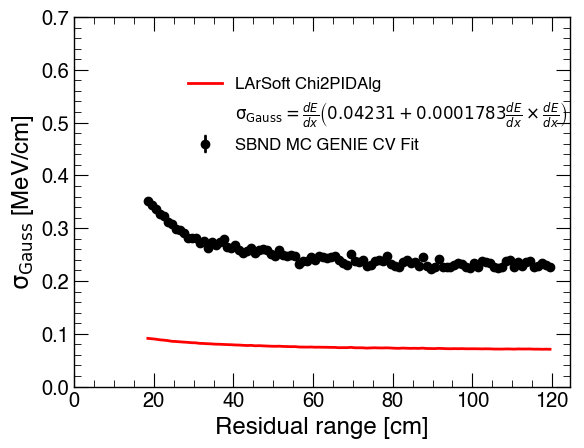

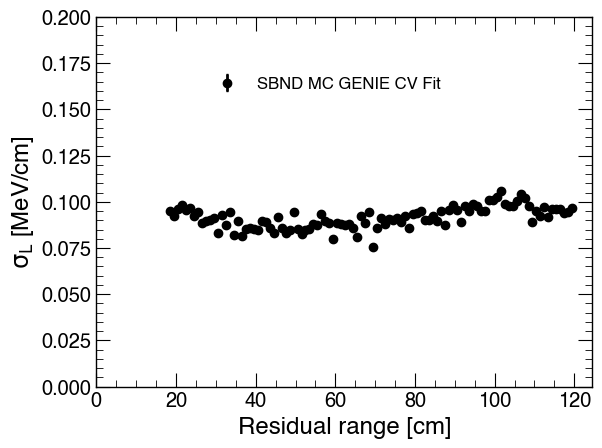

In [82]:
fit_result_vs_rr(langau_fit_par_df, 'sigma_G', r'$\mathrm{\sigma_{Gauss}}$ [MeV/cm]', '','', 0., 0.7, False)
fit_result_vs_rr(langau_fit_par_df, 'sigma_L', r'$\mathrm{\sigma_{L}}$ [MeV/cm]', '','', 0., 0.2, False)


/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/923326532.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))


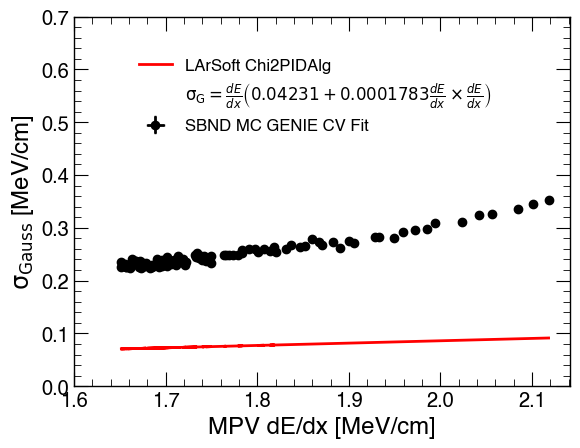

In [83]:
fit_result_vs_MPV(langau_fit_par_df, 'sigma_G', r'$\mathrm{\sigma_{Gauss}}$ [MeV/cm]', '','', False)


/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/923326532.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/923326532.py:98: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(fit_result_x, func_dedx_res(fit_result_x, *popt), 'r-', label='Fit result', color='blue', linestyle='--')
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/923326532.py:98: UserWarning: color is redundantly defined by the 'color' keyword argument and 

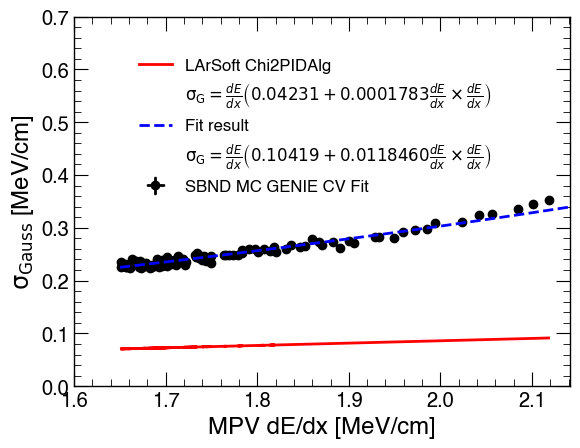

In [84]:
fit_result_vs_MPV(langau_fit_par_df, 'sigma_G', r'$\mathrm{\sigma_{Gauss}}$ [MeV/cm]', '','', True)

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/923326532.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_LArSoft'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.04231, 0.0001783))
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_45048/923326532.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_par_df['sigma_G_fit'] = this_par_df['MPV'].apply(func_dedx_res, args=(0.10419, 0.0118460))
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_4

15     0.333282
16     0.328877
17     0.324437
18     0.317388
19     0.313745
         ...   
112    0.226360
113    0.226386
114    0.225422
115    0.226276
116    0.225439
Name: sigma_G_fit, Length: 102, dtype: float64


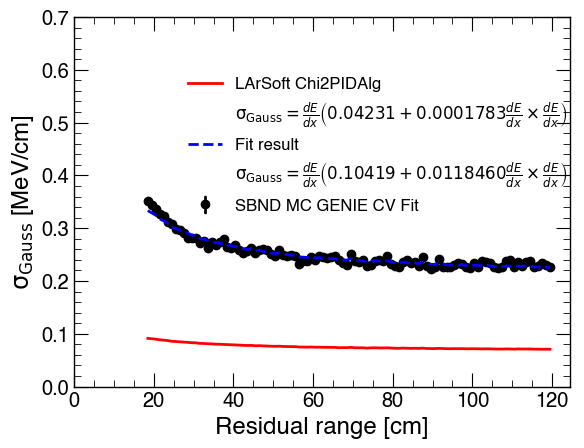

In [85]:
fit_result_vs_rr(langau_fit_par_df, 'sigma_G', r'$\mathrm{\sigma_{Gauss}}$ [MeV/cm]', '','', 0., 0.7, True)